<div class="alert alert-block alert-info">
<b>Load all the libraries and data</b> 
</div>

In [246]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import pandas as pd
import datetime
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import mean_squared_error


In [2]:
df_all = pd.read_csv('vic_elec.csv')

In [3]:
df_all.head()

Time       Demand  Temperature        Date  Holiday
0  2011-12-31T13:00:00Z  4382.825174        21.40  01/01/2012     True
1  2011-12-31T13:30:00Z  4263.365526        21.05  01/01/2012     True
2  2011-12-31T14:00:00Z  4048.966046        20.70  01/01/2012     True
3  2011-12-31T14:30:00Z  3877.563330        20.55  01/01/2012     True
4  2011-12-31T15:00:00Z  4036.229746        20.40  01/01/2012     True

In [4]:
df_all.tail()

Time       Demand  Temperature        Date  Holiday
52603  2014-12-31T10:30:00Z  3873.448714         19.0  31/12/2014    False
52604  2014-12-31T11:00:00Z  3791.637322         18.5  31/12/2014    False
52605  2014-12-31T11:30:00Z  3724.835666         17.7  31/12/2014    False
52606  2014-12-31T12:00:00Z  3761.886854         17.3  31/12/2014    False
52607  2014-12-31T12:30:00Z  3809.414586         17.1  31/12/2014    False

<div class="alert alert-block alert-info">
<b>Do simple EDA</b> 
</div>

In [5]:
df_all.shape

(52608, 5)

In [6]:
df_all.describe()

Demand   Temperature
count  52608.000000  52608.000000
mean    4665.432826     16.265071
std      874.273645      5.658849
min     2857.945728      1.500000
25%     3969.464472     12.300000
50%     4634.706032     15.400000
75%     5244.325424     19.400000
max     9345.004346     43.200000

In [7]:
df_all.isnull().sum()

Time           0
Demand         0
Temperature    0
Date           0
Holiday        0
dtype: int64

<div class="alert alert-block alert-info">
<b>Time format is wrong so change it to python readable format</b> 
</div>

In [8]:
df_all.Date.replace('/','-', inplace=True)

In [10]:
df_all['Date'] = pd.to_datetime(df_all.Date)

In [11]:
df_all = df_all.round(0)

In [12]:
df_all.head()

Time  Demand  Temperature       Date  Holiday
0  2011-12-31T13:00:00Z  4383.0         21.0 2012-01-01     True
1  2011-12-31T13:30:00Z  4263.0         21.0 2012-01-01     True
2  2011-12-31T14:00:00Z  4049.0         21.0 2012-01-01     True
3  2011-12-31T14:30:00Z  3878.0         21.0 2012-01-01     True
4  2011-12-31T15:00:00Z  4036.0         20.0 2012-01-01     True

<div class="alert alert-block alert-info">
<b>We have to predict daily demand, so aggregarting by dates here
</div>

In [54]:
df_demand = df_all.groupby(by='Date').agg({'Demand':'sum'}).reset_index()

In [14]:
df_temp = df_all.groupby(by='Date').agg({'Temperature':'mean'}).reset_index()

In [144]:
df_holiday = df_all.groupby(by='Date').agg({'Holiday':'sum'}).reset_index()

<div class="alert alert-block alert-info">
<b>Adjust the holidays dataframe for correct input into facebook prophet model</b> 
</div>

In [145]:
df_holiday.head()

Date  Holiday
0 2012-01-01       48
1 2012-01-02        0
2 2012-01-03        0
3 2012-01-04        0
4 2012-01-05        0

In [147]:
df_holiday.Holiday = df_holiday.Holiday.replace({48: True, 0: False})


In [148]:
print(df_holiday.Holiday.unique())

[ True False]


In [256]:
df_holiday.head()

ds  holiday
0 2012-01-01     True
1 2012-01-02    False
2 2012-01-03    False
3 2012-01-04    False
4 2012-01-05    False

In [154]:
df_holiday.columns = ['ds','holiday']

In [166]:
df_holiday.head()

ds  holiday
0 2012-01-01     True
1 2012-01-02    False
2 2012-01-03    False
3 2012-01-04    False
4 2012-01-05    False

In [167]:
df_holiday_new = df_holiday[df_holiday.holiday == True]

In [168]:
df_holiday_new.shape

(31, 2)

In [198]:
df_holiday_new.head()

ds  holiday
0   2012-01-01  holiday
25  2012-01-26  holiday
31  2012-02-01  holiday
115 2012-04-25  holiday
155 2012-06-04  holiday

In [199]:
df_holiday_new.holiday.value_counts()

holiday    31
Name: holiday, dtype: int64

In [197]:
df_holiday_new.holiday = df_holiday_new.holiday.replace({None: 'holiday'})

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<div class="alert alert-block alert-info">
<b>Format the Demand to input into facebook prophet model</b> 
</div>

In [257]:
df_demand.head()

Date  Demand
0 2012-01-01  222435
1 2012-01-02  230450
2 2012-01-03  230508
3 2012-01-04  190758
4 2012-01-05  229533

In [296]:
df_demand.dtypes

Date      datetime64[ns]
Demand             int32
dtype: object

In [57]:
df_demand = df_demand.sort_values(by=['Date'])

In [58]:
df_demand.Demand = df_demand.Demand.astype('int')

In [59]:
df_demand.head()

Date  Demand
0 2012-01-01  222435
1 2012-01-02  230450
2 2012-01-03  230508
3 2012-01-04  190758
4 2012-01-05  229533

--- 

In [20]:
df_temp = df_temp.sort_values(by=['Date'])

In [27]:
df_temp.Temperature = df_temp.Temperature.astype('int')

#### Start date is 01 January 2012 and the end date is 31 Dec 2014

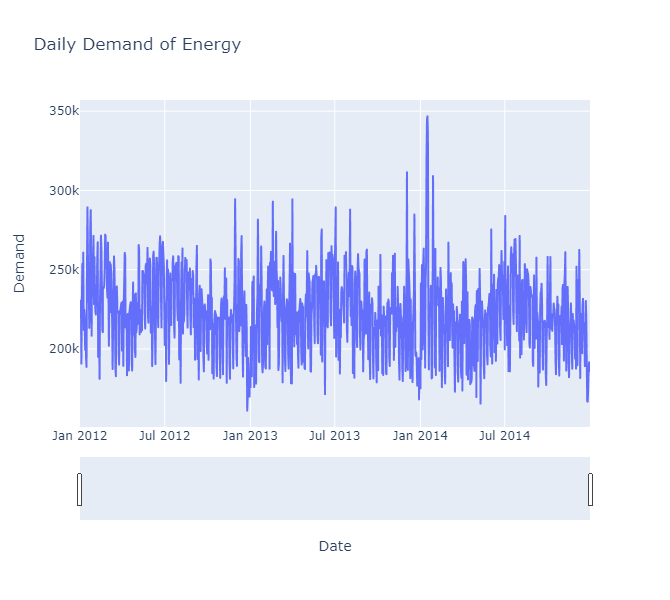

In [29]:
# for sorted frame with 
fig_line = px.line(data_frame=df_demand, title="Daily Demand of Energy",
    x='Date',
    y='Demand', height=600)

fig_line.update_xaxes(rangeslider_visible=True)

fig_line.show()


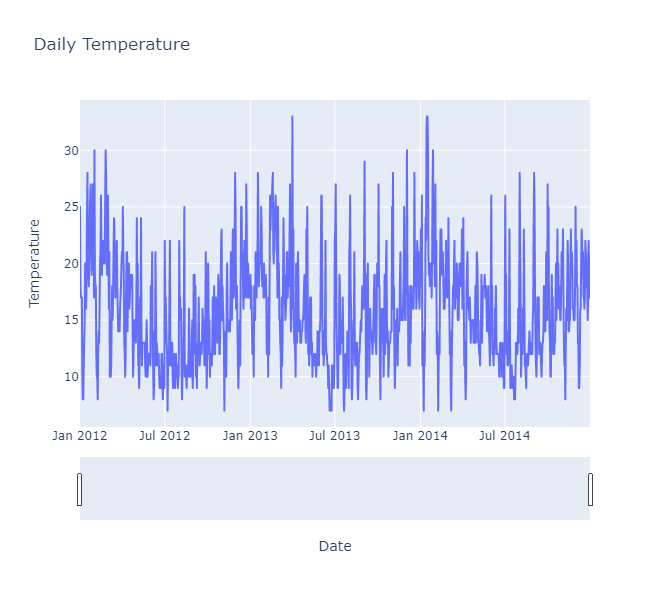

In [30]:
# for sorted frame with 
fig_line = px.line(data_frame=df_temp, title="Daily Temperature",
    x='Date',
    y='Temperature', height=600)

fig_line.update_xaxes(rangeslider_visible=True)

fig_line.show()


-----

In [259]:
df_demand.columns

Index(['Date', 'Demand'], dtype='object')

<div class="alert alert-block alert-info">
<b>Splitting into train and test set</b> 
</div>

In [261]:
split_date = '2014-06-30'
train = df_demand.loc[df_demand.Date <= split_date].copy()
test = df_demand.loc[df_demand.Date > split_date].copy()

In [297]:
train.shape

(912, 2)

In [298]:
test.shape

(184, 2)

In [265]:
train.tail()

Date  Demand
907 2014-06-26  243392
908 2014-06-27  241589
909 2014-06-28  218873
910 2014-06-29  220296
911 2014-06-30  255009

In [266]:
test.tail()

Date  Demand
1091 2014-12-27  173638
1092 2014-12-28  188111
1093 2014-12-29  191597
1094 2014-12-30  186101
1095 2014-12-31  186198

In [267]:
#Change to facebook default column names
train.columns = ['ds','y']

In [268]:
# The ds column is facebook prophet should be date time, so lets check this
train.dtypes

ds    datetime64[ns]
y              int32
dtype: object

In [86]:
test.head()

Date  Demand
731 2014-01-01  175187
732 2014-01-02  241285
733 2014-01-03  193713
734 2014-01-04  252879
735 2014-01-05  234151

In [269]:
test.columns

Index(['Date', 'Demand'], dtype='object')

In [270]:
test.columns = ['ds', 'y']

<div class="alert alert-block alert-info">
<b>model_1 : Applying basic model of FB Prophet and getting the plot+metrics</b> 
</div>

In [302]:
# Simple basic model 
# Seasonality_mode=multiplicative becasue it is demand, and the demand can't be negative !

model_1=Prophet(seasonality_mode='multiplicative', daily_seasonality=True)
model_1.fit(train)

In [304]:
# making future dates for 184 days (6 months)
future_dates = model.make_future_dataframe(periods=184)

In [305]:
future_dates.tail()

ds
1091 2014-12-27
1092 2014-12-28
1093 2014-12-29
1094 2014-12-30
1095 2014-12-31

In [306]:
forecast_1 = model_1.predict(future_dates)

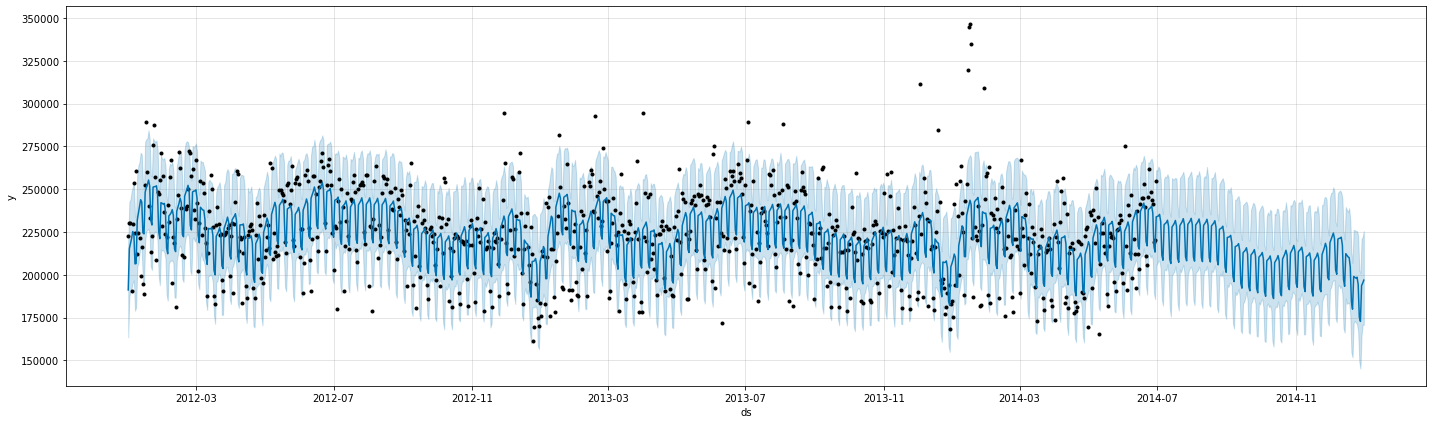

In [307]:
model_1.plot(forecast_1, figsize=(20, 6));

In [308]:
forecast_1

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0    2012-01-01  226889.866823  163404.375329  218436.321470  226889.866823   
1    2012-01-02  226873.013202  187067.319738  242710.478960  226873.013202   
2    2012-01-03  226856.159580  190917.618249  243843.434787  226856.159580   
3    2012-01-04  226839.305958  192155.300276  248354.178967  226839.305958   
4    2012-01-05  226822.452336  195372.843753  251285.752673  226822.452336   
...         ...            ...            ...            ...            ...   
1091 2014-12-27  207839.182657  149190.501666  202563.680287  207194.683108   
1092 2014-12-28  207808.948615  145168.096157  200921.293200  207162.570184   
1093 2014-12-29  207778.714573  164845.268127  220823.668730  207129.697434   
1094 2014-12-30  207748.480531  170779.568922  222085.547580  207092.763825   
1095 2014-12-31  207718.246489  170726.904353  225468.746928  207059.711922   

        trend_upper    daily  daily_lower  daily_upper  multiplicative_terms  \
0     226889.866823  0.01595      0.01595      0.01595             -0.157727   
1     226873.013202  0.01595      0.01595      0.01595             -0.051242   
2     226856.159580  0.01595      0.01595      0.01595             -0.038496   
3     226839.305958  0.01595      0.01595      0.01595             -0.024743   
4     226822.452336  0.01595      0.01595      0.01595             -0.006954   
...             ...      ...          ...          ...                   ...   
1091  208487.738247  0.01595      0.01595      0.01595             -0.156742   
1092  208466.325217  0.01595      0.01595      0.01595             -0.168807   
1093  208445.874430  0.01595      0.01595      0.01595             -0.068082   
1094  208423.243914  0.01595      0.01595      0.01595             -0.060855   
1095  208400.522069  0.01595      0.01595      0.01595             -0.052260   

      ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     ... -0.077561     -0.077561     -0.077561 -0.096116     -0.096116   
1     ...  0.022373      0.022373      0.022373 -0.089565     -0.089565   
2     ...  0.027221      0.027221      0.027221 -0.081667     -0.081667   
3     ...  0.031867      0.031867      0.031867 -0.072560     -0.072560   
4     ...  0.039508      0.039508      0.039508 -0.062412     -0.062412   
...   ...       ...           ...           ...       ...           ...   
1091  ... -0.066275     -0.066275     -0.066275 -0.106417     -0.106417   
1092  ... -0.077561     -0.077561     -0.077561 -0.107196     -0.107196   
1093  ...  0.022373      0.022373      0.022373 -0.106405     -0.106405   
1094  ...  0.027221      0.027221      0.027221 -0.104026     -0.104026   
1095  ...  0.031867      0.031867      0.031867 -0.100078     -0.100078   

      yearly_upper  additive_terms  additive_terms_lower  \
0        -0.096116             0.0                   0.0   
1        -0.089565             0.0                   0.0   
2        -0.081667             0.0                   0.0   
3        -0.072560             0.0                   0.0   
4        -0.062412             0.0                   0.0   
...            ...             ...                   ...   
1091     -0.106417             0.0                   0.0   
1092     -0.107196             0.0                   0.0   
1093     -0.106405             0.0                   0.0   
1094     -0.104026             0.0                   0.0   
1095     -0.100078             0.0                   0.0   

      additive_terms_upper           yhat  
0                      0.0  191103.281598  
1                      0.0  215247.509959  
2                      0.0  218123.094920  
3                      0.0  221226.641788  
4                      0.0  225245.087864  
...                    ...            ...  
1091                   0.0  175262.135891  
1092                   0.0  172729.422051  
1093                   0.0  193632.786845  
1094                   0.0  195105.889123

In [310]:
forecast_1.shape

(1096, 22)

In [311]:
only_forecast_1 = forecast_1.iloc[912:]

In [312]:
only_forecast_1.shape

(184, 22)

In [313]:
test.columns

Index(['ds', 'y'], dtype='object')

In [314]:
only_forecast_1.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
912 2014-07-01  213251.076178  206543.236884  260658.081592  213251.076178   
913 2014-07-02  213220.842136  208296.379090  263208.671941  213220.842136   
914 2014-07-03  213190.608094  207792.137173  261879.703457  213190.608094   
915 2014-07-04  213160.374052  203585.898978  255639.459187  213160.374052   
916 2014-07-05  213130.140010  185636.080540  239177.731193  213130.140010   

       trend_upper    daily  daily_lower  daily_upper  multiplicative_terms  \
912  213251.076178  0.01595      0.01595      0.01595              0.097720   
913  213220.842136  0.01595      0.01595      0.01595              0.099069   
914  213190.608094  0.01595      0.01595      0.01595              0.103529   
915  213160.374052  0.01595      0.01595      0.01595              0.083889   
916  213130.140010  0.01595      0.01595      0.01595             -0.008017   

     ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
912  ...  0.027221      0.027221      0.027221  0.054549      0.054549   
913  ...  0.031867      0.031867      0.031867  0.051251      0.051251   
914  ...  0.039508      0.039508      0.039508  0.048071      0.048071   
915  ...  0.022868      0.022868      0.022868  0.045072      0.045072   
916  ... -0.066275     -0.066275     -0.066275  0.042307      0.042307   

     yearly_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
912      0.054549             0.0                   0.0                   0.0   
913      0.051251             0.0                   0.0                   0.0   
914      0.048071             0.0                   0.0                   0.0   
915      0.045072             0.0                   0.0                   0.0   
916      0.042307             0.0                   0.0                   0.0   

              yhat  
912  234090.010959  
913  234344.312475  
914  235261.981164  
915  231042.278882  
916  211421.394355  

[5 rows x 22 columns]

In [315]:
y_true= np.array(test.y)

In [317]:
only_forecast_1.yhat = only_forecast.yhat.astype('int')

In [322]:
y_pred = np.array(only_forecast_1.yhat)

In [319]:
len(y_true)

184

In [323]:
len(y_pred)

184

<div class="alert alert-block alert-info">
<b>Getting the error metrics</b> 
</div>

In [324]:
mean_squared_error(y_true,
                   y_pred)

188679812.88586956

In [325]:
from sklearn.metrics import mean_absolute_error

In [326]:
mean_absolute_error(y_true,
                    y_pred)

14003.91847826087

In [330]:
mean_squared_error(y_true,
                   y_pred,squared=False)

13736.077055908996

##### The prediction is not looking great,so lets see the components as well !

<div class="alert alert-block alert-info">
<b>Looking at the components of the model</b> 
</div>

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



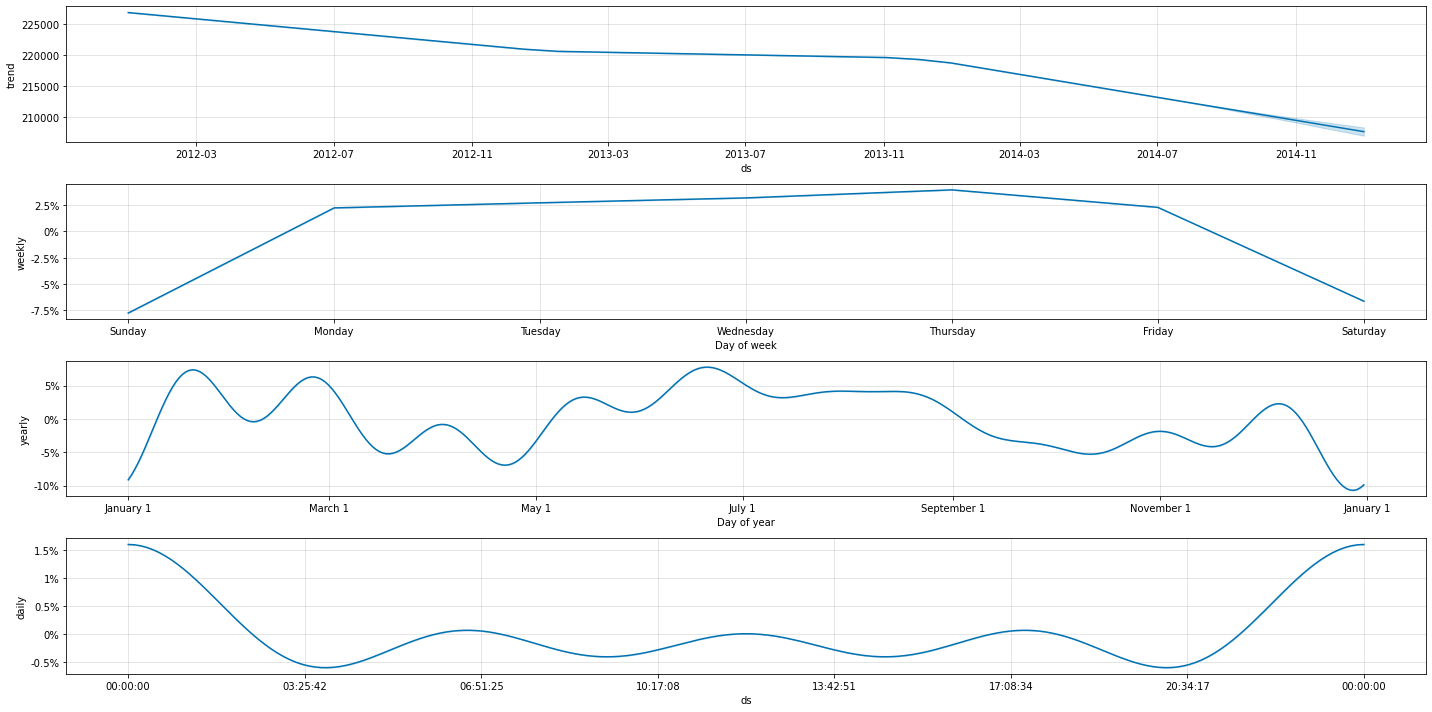

In [328]:
fig=model_1.plot_components(forecast_1, figsize=(20, 10))

##### The simple off the shelf model has not worked very well


In [ ]:
# seasonality_mode is multiplicative becasue it is demand, and the demand can't be negative !
model=Prophet(seasonality_mode='multiplicative', 
              daily_seasonality=True, holidays=df_holiday_new)
model.fit(train)

<div class="alert alert-block alert-info">
<b>model_2 : Add holidays dataframe in the model</b> 
</div>

In [356]:
model_2 = Prophet(seasonality_mode='multiplicative', 
                  daily_seasonality=True,
                  holidays=df_holiday_new)

model_2.fit(train)


C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\forecaster.py:171: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [357]:
forecast_2 = model_2.predict(future_dates)

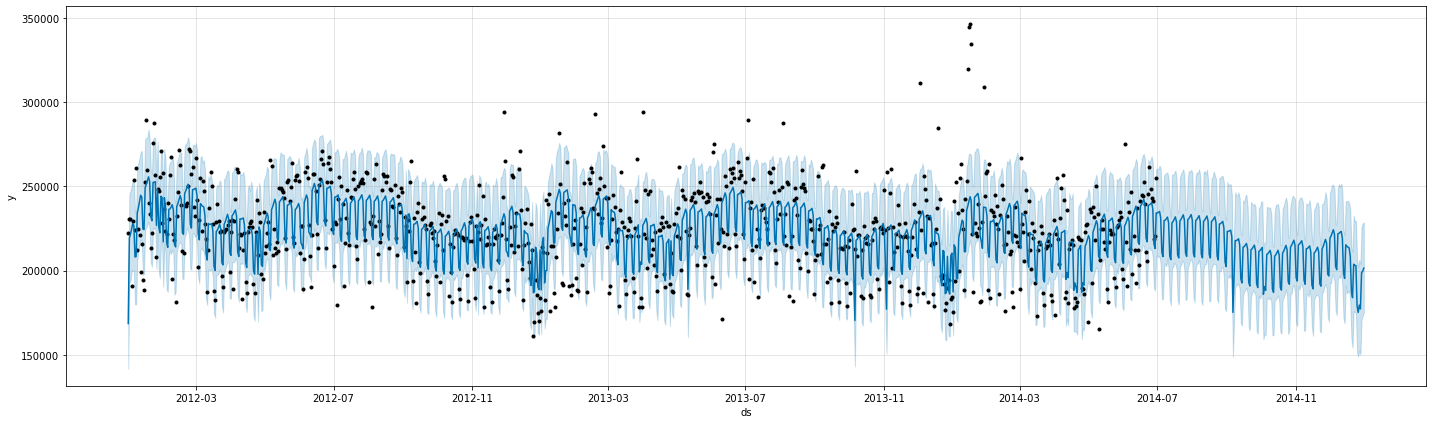

In [358]:
model_2.plot(forecast_2, figsize=(20, 6));

In [364]:
forecast_2

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0    2012-01-01  228116.052552  141848.616636  195999.900602  228116.052552   
1    2012-01-02  228099.774352  193055.728791  245423.748277  228099.774352   
2    2012-01-03  228083.496152  193564.453658  247365.178943  228083.496152   
3    2012-01-04  228067.217952  199192.091004  249974.086000  228067.217952   
4    2012-01-05  228050.939752  200694.326627  253578.200951  228050.939752   
...         ...            ...            ...            ...            ...   
1091 2014-12-27  209692.220958  152957.416476  206397.093164  209159.385627   
1092 2014-12-28  209664.017608  150144.472941  203952.134396  209124.547704   
1093 2014-12-29  209635.814259  171073.295163  225955.905903  209090.495963   
1094 2014-12-30  209607.610909  173207.598233  228048.020778  209062.797125   
1095 2014-12-31  209579.407560  175223.593675  228663.943665  209022.649124   

        trend_upper     daily  daily_lower  daily_upper   holiday  ...  \
0     228116.052552  0.013491     0.013491     0.013491 -0.115105  ...   
1     228099.774352  0.013491     0.013491     0.013491  0.000000  ...   
2     228083.496152  0.013491     0.013491     0.013491  0.000000  ...   
3     228067.217952  0.013491     0.013491     0.013491  0.000000  ...   
4     228050.939752  0.013491     0.013491     0.013491  0.000000  ...   
...             ...       ...          ...          ...       ...  ...   
1091  210219.724383  0.013491     0.013491     0.013491  0.000000  ...   
1092  210197.539871  0.013491     0.013491     0.013491  0.000000  ...   
1093  210177.434177  0.013491     0.013491     0.013491  0.000000  ...   
1094  210156.643960  0.013491     0.013491     0.013491  0.000000  ...   
1095  210134.614851  0.013491     0.013491     0.013491  0.000000  ...   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0    -0.077912     -0.077912     -0.077912 -0.081421     -0.081421   
1     0.024088      0.024088      0.024088 -0.075886     -0.075886   
2     0.027204      0.027204      0.027204 -0.069111     -0.069111   
3     0.032748      0.032748      0.032748 -0.061211     -0.061211   
4     0.038576      0.038576      0.038576 -0.052326     -0.052326   
...        ...           ...           ...       ...           ...   
1091 -0.068377     -0.068377     -0.068377 -0.088997     -0.088997   
1092 -0.077912     -0.077912     -0.077912 -0.090013     -0.090013   
1093  0.024088      0.024088      0.024088 -0.089650     -0.089650   
1094  0.027204      0.027204      0.027204 -0.087880     -0.087880   
1095  0.032748      0.032748      0.032748 -0.084705     -0.084705   

      yearly_upper  additive_terms  additive_terms_lower  \
0        -0.081421             0.0                   0.0   
1        -0.075886             0.0                   0.0   
2        -0.069111             0.0                   0.0   
3        -0.061211             0.0                   0.0   
4        -0.052326             0.0                   0.0   
...            ...             ...                   ...   
1091     -0.088997             0.0                   0.0   
1092     -0.090013             0.0                   0.0   
1093     -0.089650             0.0                   0.0   
1094     -0.087880             0.0                   0.0   
1095     -0.084705             0.0                   0.0   

      additive_terms_upper           yhat  
0                      0.0  168589.819381  
1                      0.0  219361.951102  
2                      0.0  221602.191277  
3                      0.0  224652.529112  
4                      0.0  227991.998732  
...                    ...            ...  
1091                   0.0  179520.867684  
1092                   0.0  177284.819981  
1093                   0.0  198719.944005  
1094                   0.0  199717.320999  
1095                   0.0  201517.701827  

[1096 rows x 28 columns]

In [363]:
test.head()

ds       y
912 2014-07-01  199770
913 2014-07-02  283899
914 2014-07-03  215901
915 2014-07-04  218475
916 2014-07-05  240361

In [359]:
y_pred_2 = forecast_2.yhat.iloc[912:]

In [360]:
len(y_pred_2)

184

In [361]:
mean_absolute_error(y_true,
                    y_pred_2)

15208.441416600972

In [362]:
mean_squared_error(y_true,
                   y_pred_2,squared=False)

20255.39534388287

Adding holidays dataframe has given worse metrics, which means it hasnt worked well yet !

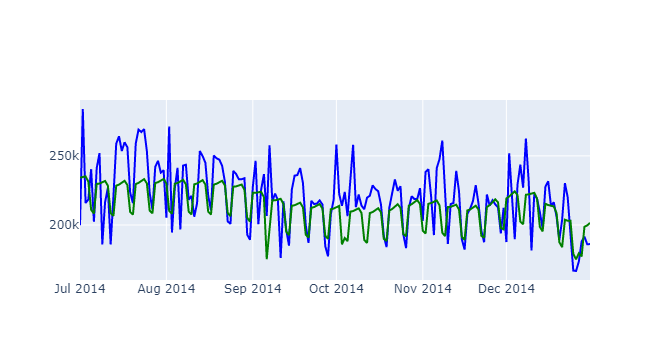

In [368]:
import pandas as pd
import plotly.graph_objects as go


# set up plotly figure
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=test.ds,
    y=test.y,
    marker=dict(
        color="blue"
    ),
    showlegend=False
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=test.ds,
    y=y_pred_2,
    marker=dict(
        color="green"
    ),
    showlegend=False
))

fig.show()

<div class="alert alert-block alert-info">
<b>model_3 : Add temperature in the model</b> 
</div>

In [398]:
df_temp.head()

Date  Temperature
0 2012-01-01           25
1 2012-01-02           18
2 2012-01-03           17
3 2012-01-04           17
4 2012-01-05           17

In [399]:
df_temp.shape

(1096, 2)

In [400]:
split_date = '2014-06-30'
train_temp = df_temp.loc[df_temp.Date <= split_date].copy()
test_temp = df_temp.loc[df_temp.Date > split_date].copy()

In [401]:
train_temp.shape

(912, 2)

In [402]:
test_temp.shape

(184, 2)

In [403]:
train_3 = train

In [407]:
train_3.shape

(912, 3)

In [408]:
train_3['temp'] = train_temp.Temperature 

In [409]:
test_3 = test

In [410]:
test_3['temp'] = test_temp.Temperature 

In [412]:
test_3.shape

(184, 3)

In [513]:
model_3 = Prophet(seasonality_mode='multiplicative',
                  daily_seasonality=False,
                  yearly_seasonality=7,
                  weekly_seasonality=10,
                  seasonality_prior_scale=0.01,
                  holidays=df_holiday_new
                 )
model_3.add_regressor('temp')

model_3.fit(train_3)


C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\forecaster.py:171: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [484]:
future_dates.head()

ds  temp
0 2012-01-01    25
1 2012-01-02    18
2 2012-01-03    17
3 2012-01-04    17
4 2012-01-05    17

In [485]:
future_dates.shape

(1096, 2)

In [514]:
future_dates = model_3.make_future_dataframe(periods=184)

future_dates['temp'] = df_temp.Temperature

forecast_3 = model_3.predict(future_dates)


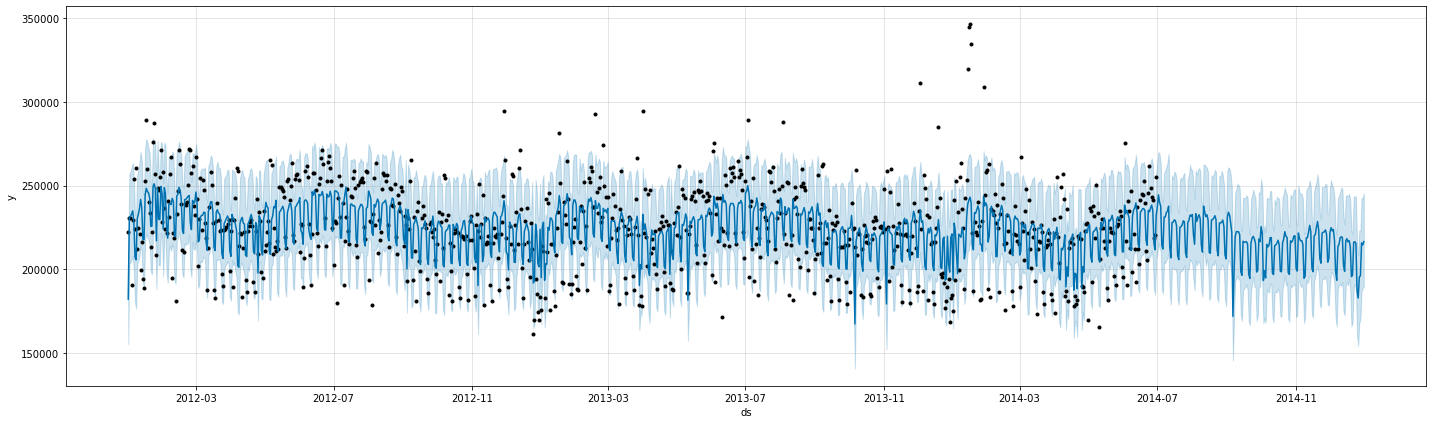

In [515]:
model_3.plot(forecast_3, figsize=(20, 6));

In [516]:
y_pred_3 = forecast_3.yhat.iloc[912:]

In [517]:
mean_absolute_error(y_true,
                    y_pred_3)

15665.256213325729

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



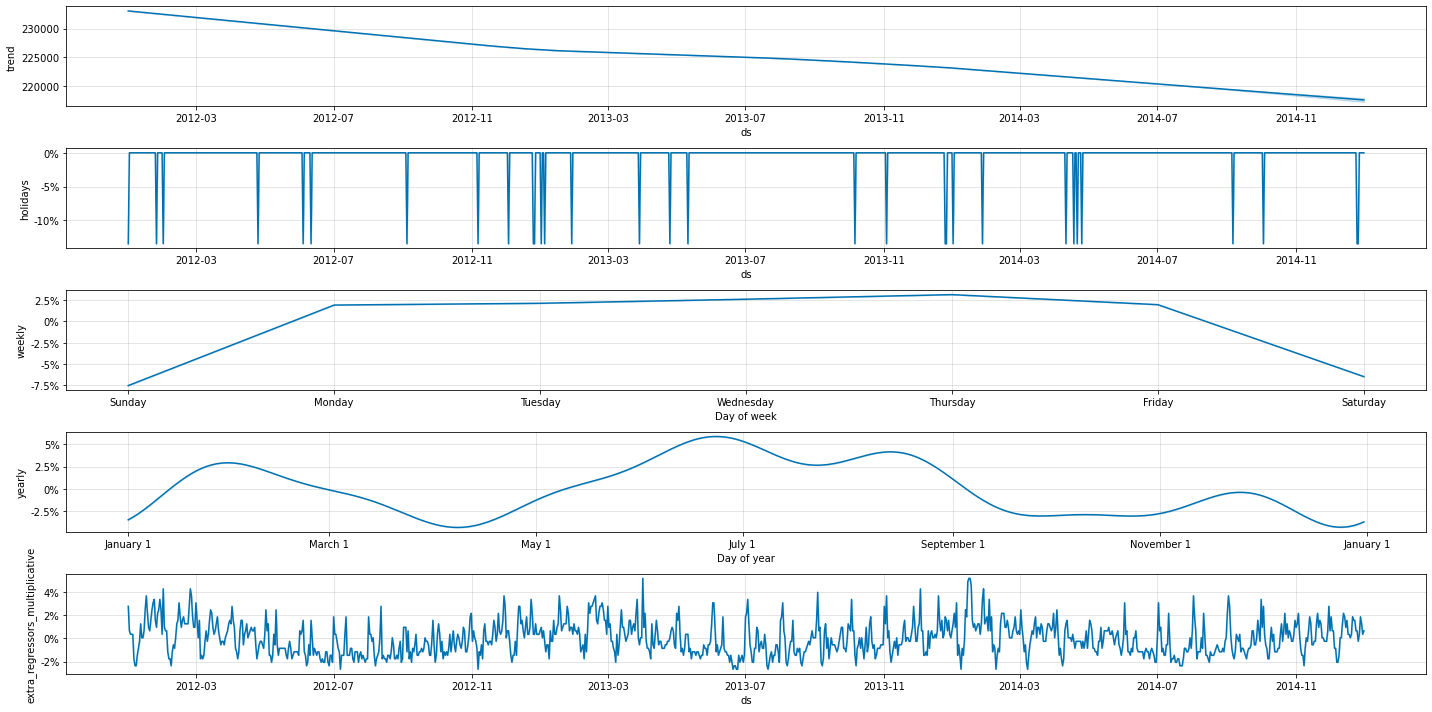

In [518]:
fig_3=model_3.plot_components(forecast_3, figsize=(20, 10))